In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import librosa
import soundfile as sf
import io


base_dir=f'{Path(os.getcwd()).parent}'
sys.path.append(base_dir)
sys.path.append(base_dir+'/MoeGoe')

from MoeGoe.MoeGoe import *



In [2]:
dev = "cuda:0"
model = f'{base_dir}/vits_models/ruise/1158_epochs.pth'
config = f'{base_dir}/vits_models/ruise/config.json'
hps_ms = utils.get_hparams_from_file(config)
n_speakers = hps_ms.data.n_speakers if 'n_speakers' in hps_ms.data.keys() else 0
n_symbols = len(hps_ms.symbols) if 'symbols' in hps_ms.keys() else 0
speakers = hps_ms.speakers if 'speakers' in hps_ms.keys() else ['0']
use_f0 = hps_ms.data.use_f0 if 'use_f0' in hps_ms.data.keys() else False
emotion_embedding = hps_ms.data.emotion_embedding if 'emotion_embedding' in hps_ms.data.keys() else False
net_g_ms = SynthesizerTrn(
    n_symbols,
    hps_ms.data.filter_length // 2 + 1,
    hps_ms.train.segment_size // hps_ms.data.hop_length,
    n_speakers=n_speakers,
    emotion_embedding=emotion_embedding,
    **hps_ms.model).to(dev)
_ = net_g_ms.eval()
speaker_id = 24
utils.load_checkpoint(model, net_g_ms)


In [17]:
text="わたくしはその人を常に先生と呼んでいた。だからここでもただ先生と書くだけで本名は打ち明けない。"
speaker_id = 3

#text="[LENGTH=3.0]あーーーーーーーーーーーーーーーーーーーーーー"

length_scale, text = get_label_value(text, 'LENGTH', 1, 'length scale')
noise_scale, text = get_label_value(text, 'NOISE', 0.667, 'noise scale')
noise_scale_w, text = get_label_value(text, 'NOISEW', 0.8, 'deviation of noise')
cleaned, text = get_label(text, 'CLEANED')
stn_tst = get_text(text, hps_ms, cleaned=cleaned)
with no_grad():
    x_tst = stn_tst.unsqueeze(0).to(dev)
    x_tst_lengths = LongTensor([stn_tst.size(0)]).to(dev)
    sid = LongTensor([speaker_id]).to(dev)
    # black magic
    audio = net_g_ms.infer(x_tst, x_tst_lengths, sid=sid, noise_scale=noise_scale,
                        noise_scale_w=noise_scale_w, length_scale=length_scale)[0][0, 0].data.cpu().float().numpy()
    # convert sample rate to 24000 using scipy
    audio = audio.astype(np.float32)
    audio = librosa.resample(audio, orig_sr=22050, target_sr=24000)

In [7]:
import numpy as np
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [18]:
filtered_audio=butter_bandpass_filter(audio, 500, 4250, 24000)

In [19]:
f = io.BytesIO() # create a memory file
sf.write(f, filtered_audio, 24000, format='WAV')


import IPython.display
IPython.display.Audio(f.getvalue(), rate=24000)

In [22]:
from libs.tune import autotune
import psola

# ピッチを強制的に変更する frame_length=2048, hop_length=512
audio2 = autotune(audio, 24000,"C:min",0)
audio3 = autotune(filtered_audio, 24000,"C:min",5)

#base_pitch=librosa.midi_to_hz(50)
#pitchs = np.array([base_pitch] * (int(len(audio)/512)+1),dtype=np.float32)
#audio2 = psola.vocode(audio, sample_rate=24000, target_pitch=pitchs, fmin=20.0, fmax=5000.0)

# audio と audio2 を合成する
audio4 = audio2 + audio3

# 1秒ほど伸ばす
# audio = np.concatenate([audio,np.zeros(int(24000/2),dtype=np.float32)])

In [23]:
f = io.BytesIO() # create a memory file
sf.write(f, audio4, 24000, format='WAV')


import IPython.display
IPython.display.Audio(f.getvalue(), rate=24000)


: 

In [71]:
# テスト用の440Hzのサイン波を作成する
sample_rate = 24000
duration = 1
frequency = 440

t = np.arange(0, duration, 1/sample_rate)
audio = np.sin(2*np.pi*frequency*t)

150
1024
1024


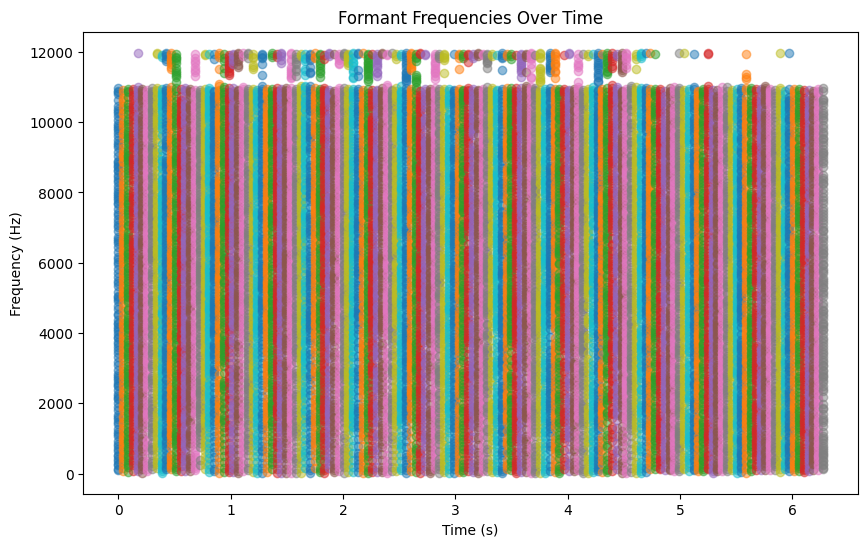

In [81]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
from scipy.io import wavfile

# サンプルレート
fs = 24000

# 窓関数を適用してフレーム化する
frame_length = 1024
frame_stride = 512

frames = [audio[i:i+frame_length] for i in range(0, len(audio), frame_stride)]

print(len(frames))
print(len(frames[0]))
# 窓関数の適用
window = np.hamming(frame_length)
print(len(window))
frames = [frame * window for frame in frames if len(frame) == frame_length]

# フレームごとのスペクトルの計算
spectrums = [np.abs(np.fft.rfft(frame)) for frame in frames]

# ピーク検出とフォルマントの追跡
formants = []
for spectrum in spectrums:
    peaks, _ = sp.find_peaks(spectrum)
    formant_frequencies = peaks * fs / frame_length
    formants.append(formant_frequencies)

# フレームごとの時間を計算
times = np.arange(len(formants)) * (frame_length / fs)

# フォルマント周波数の変化をプロット
plt.figure(figsize=(10, 6))
for i, formant_frequencies in enumerate(formants):
    plt.scatter([times[i]] * len(formant_frequencies), formant_frequencies, alpha=0.5)
plt.title('Formant Frequencies Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()